# Non-parametric Period Detection (NPPD)
This notebook demonstrates the implementation of the NPPD framework used in the study.

## Functions for NPPD
Please **run all the cells in this section** before proceeding to the demonstration below.  
The subsequent examples assume that these functions have been successfully loaded into the environment.

### Functions for Step 1: Compute local significance score w(t)

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact
from joblib import Parallel, delayed


def _calc_w_for_one_series(series, window_size, use_haldane=True):
    """
    Compute the local significance score w(t) for a single time series
    based on Fisher’s exact test applied to short-term fluctuations.

    Parameters
    ----------
    series : pandas.Series
        Time-series data (e.g., relative abundance of one MAG).
    window_size : int
        Half-width of the time window (in time steps, e.g., 12 for 12 hours).
    use_haldane : bool, optional (default=True)
        Whether to apply the Haldane–Anscombe correction to the odds ratio.

    Returns
    -------
    w_series : pandas.Series
        Local significance score w(t) at each time point.
    odds_series : pandas.Series
        (Optionally corrected) odds ratio corresponding to each test.
    """

    total_window = 2 * window_size
    T = series.shape[0]

    # Step 1: Remove long-term drift using a centered moving median (e.g., 24-hour window)
    smoothed = series.rolling(window=total_window, center=True, min_periods=1).median()
    y = series - smoothed

    w_list, odds_list = [], []
    p_min = 1e-300  # Numerical floor for log(p)

    for t in range(T):
        # Define the local analysis window around the current time point
        if t - window_size < 0:
            start = 0
            end = total_window
        elif t + window_size >= T:
            end = T
            start = max(0, T - total_window)
        else:
            start = t - window_size
            end = t + window_size

        y_window = y.iloc[start:end]
        center = t - start

        # According to NPPD definition:
        # past  = {t−k | k=1..window_size} → does NOT include t
        # future = {t+k | k=0..window_size−1} → includes t itself
        past = y_window.iloc[:center].dropna()
        future = y_window.iloc[center:].dropna()

        med = np.nanmedian(y_window)

        # Count the number of points above or below the local median in each window
        a = np.sum(past > med)
        c = np.sum(past <= med)
        b = np.sum(future > med)
        d = np.sum(future <= med)

        try:
            # Compute Fisher’s exact test
            sign = np.sign(a * d - b * c)
            _, p = fisher_exact([[a, b], [c, d]], alternative="two-sided")
            w = sign * np.log10(max(p, p_min))  # signed log p-value

            # Compute odds ratio (with or without Haldane–Anscombe correction)
            if use_haldane:
                odds_ratio = ((a + 0.5) * (d + 0.5)) / ((b + 0.5) * (c + 0.5))
            else:
                odds_ratio, _ = fisher_exact([[a, b], [c, d]])

        except Exception:
            w = np.nan
            odds_ratio = np.nan

        w_list.append(w)
        odds_list.append(odds_ratio)

    return (
        pd.Series(w_list, index=series.index),
        pd.Series(odds_list, index=series.index),
    )


def calc_wscore_parallel(x_df, window_size, use_haldane=True, n_jobs=-1, return_odds=False):
    """
    Compute the local significance score w(t) for multiple time series in parallel.

    Parameters
    ----------
    x_df : pandas.DataFrame
        Input matrix of time-series data (rows = taxa/MAGs, columns = time points).
    window_size : int
        Half-width of the local window (in time steps).
    use_haldane : bool, optional (default=True)
        Whether to apply the Haldane–Anscombe correction to the odds ratio.
    n_jobs : int, optional (default=-1)
        Number of CPU cores to use for parallel processing.
    return_odds : bool, optional (default=False)
        If True, returns both w-scores and odds ratios.

    Returns
    -------
    w_df : pandas.DataFrame
        Matrix of w(t) values for all rows.
    odds_df : pandas.DataFrame, optional
        Matrix of odds ratios (returned only if return_odds=True).
    """

    results = Parallel(n_jobs=n_jobs)(
        delayed(_calc_w_for_one_series)(x_df.loc[idx], window_size, use_haldane)
        for idx in x_df.index
    )

    w_df = pd.DataFrame({idx: res[0] for idx, res in zip(x_df.index, results)}).T
    odds_df = pd.DataFrame({idx: res[1] for idx, res in zip(x_df.index, results)}).T

    if return_odds:
        return w_df, odds_df
    else:
        return w_df

### Functions for Step 2: Assign phase θ(t)

In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd
from typing import Iterable, Tuple, Dict, Optional


# ========= Utilities for wrapping / unwrapping phases =========

def wrap_to_mpi_pi(phi: Iterable[float]) -> np.ndarray:
    """
    Wrap arbitrary phase values to the centered principal interval [-pi, pi).

    Parameters
    ----------
    phi : array-like
        Phase values (radians).

    Returns
    -------
    np.ndarray
        Wrapped phases in [-pi, pi).
    """
    phi = np.asarray(phi, dtype=float)
    return (phi + np.pi) % (2 * np.pi) - np.pi


def unwrap_phase(phi_wrapped: Iterable[float]) -> np.ndarray:
    """
    Unwrap a wrapped phase sequence to a continuous (monotone) phase.

    Parameters
    ----------
    phi_wrapped : array-like
        Wrapped phases (e.g., in [0, 2pi) or [-pi, pi)).

    Returns
    -------
    np.ndarray
        Unwrapped (continuous) phases.
    """
    return np.unwrap(np.asarray(phi_wrapped, dtype=float))


# ========= Zero-crossing helpers =========

def moving_average_fixed_endpoints(x: Iterable[float], win: int = 5) -> np.ndarray:
    """
    NaN-robust moving average that preserves original endpoint values.

    Parameters
    ----------
    x : array-like
        Input series.
    win : int, optional
        Window length (must be >=1). If even, it is incremented to be odd.

    Returns
    -------
    np.ndarray
        Smoothed series with endpoints kept as original values.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    if n == 0:
        return x

    # Linear interpolation for NaNs (fallback to 0 if insufficient finite values)
    idx = np.arange(n)
    m = np.isfinite(x)
    if m.sum() >= 2:
        x_fill = np.interp(idx, idx[m], x[m])
    else:
        x_fill = np.nan_to_num(x, nan=0.0)

    win = max(1, int(win))
    if win % 2 == 0:
        win += 1
    half = win // 2

    out = np.empty_like(x_fill)
    for i in range(n):
        if i < half or i > n - 1 - half:
            out[i] = x_fill[i]
        else:
            sl = slice(i - half, i + half + 1)
            out[i] = np.mean(x_fill[sl])
    return out


def detect_zero_crossings_with_zero_blocks(
    y: Iterable[float],
    time: Optional[Iterable[float]] = None,
    eps: float = 0.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Detect zero-crossings in a series that may contain long zero blocks.
    Two types of crossings are returned:
      - positive-to-negative (p→n)
      - negative-to-positive (n→p)

    Detection rules
    ---------------
    1) Adjacent sign flips (+→- / -→+) are detected directly.
    2) Consecutive zero blocks are treated as one segment; if signs before and
       after the block differ, a crossing is added across the block.
    Crossing times are linearly interpolated using neighboring non-zero points.

    Parameters
    ----------
    y : array-like
        1D series.
    time : array-like, optional
        Time coordinates. If None, uses integer indices [0, 1, ..., n-1].
    eps : float, optional
        Values with |y| <= eps are treated as zero.

    Returns
    -------
    t_p2n : np.ndarray
        Crossing times for +→- (float).
    t_n2p : np.ndarray
        Crossing times for -→+ (float).
    """
    y = np.asarray(y, dtype=float)
    n = len(y)
    if n < 2:
        return np.array([]), np.array([])

    time = np.arange(n, dtype=float) if time is None else np.asarray(time, dtype=float)
    yz = y.copy()
    if eps > 0:
        yz[np.abs(yz) <= eps] = 0.0

    t_p2n, t_n2p = [], []

    def interp_time(i: int, j: int) -> float:
        yi, yj = y[i], y[j]
        ti, tj = time[i], time[j]
        return ti if yi == yj else ti + (tj - ti) * yi / (yi - yj)

    # 1) Direct two-point sign flips
    y0, y1 = yz[:-1], yz[1:]
    for i in np.where((y0 > 0) & (y1 < 0))[0]:
        t_p2n.append(interp_time(i, i + 1))
    for i in np.where((y0 < 0) & (y1 > 0))[0]:
        t_n2p.append(interp_time(i, i + 1))

    # 2) Zero-block handling
    z = (yz == 0.0)
    dz = np.diff(z.astype(int), prepend=0, append=0)
    starts = np.where(dz == 1)[0]
    ends = np.where(dz == -1)[0] - 1

    for s, e in zip(starts, ends):
        i_left, j_right = s - 1, e + 1

        # Internal block
        if (i_left >= 0) and (j_right < n):
            if yz[i_left] > 0 and yz[j_right] < 0:
                t_p2n.append(interp_time(i_left, j_right))
            elif yz[i_left] < 0 and yz[j_right] > 0:
                t_n2p.append(interp_time(i_left, j_right))

        # Left-edge block
        elif i_left < 0 and j_right < n:
            if yz[j_right] > 0:
                t_n2p.append(float(e))  # -→0→+
            elif yz[j_right] < 0:
                t_p2n.append(float(e))  # +→0→-

        # Right-edge block
        elif j_right >= n and i_left >= 0:
            if yz[i_left] > 0:
                t_p2n.append(float(s))  # +→0→-
            elif yz[i_left] < 0:
                t_n2p.append(float(s))  # -→0→+

    return np.unique(np.round(t_p2n, 12)), np.unique(np.round(t_n2p, 12))


def get_zero_crossing_times(ws: Iterable[float], time: Iterable[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Get ordered zero-crossing times and their types from a smoothed series.

    Parameters
    ----------
    ws : array-like
        Smoothed series (e.g., smoothed w(t)).
    time : array-like
        Time coordinates.

    Returns
    -------
    t_all : np.ndarray
        Sorted crossing times.
    kind : np.ndarray
        Crossing type for each time (0: p→n, 1: n→p).
    """
    t_p2n, t_n2p = detect_zero_crossings_with_zero_blocks(ws, time=time, eps=0.0)
    t_all = np.r_[t_p2n, t_n2p]
    kind = np.r_[np.zeros_like(t_p2n), np.ones_like(t_n2p)]  # 0: p→n, 1: n→p
    order = np.argsort(t_all)
    return t_all[order], kind[order]


def window_indices_between(t0: float, t1: float, time: Iterable[float]) -> slice:
    """
    Return the index slice corresponding to the interval (t0, t1).

    Parameters
    ----------
    t0, t1 : float
        Interval bounds.
    time : array-like
        Time coordinates.

    Returns
    -------
    slice
        Slice covering indices within (t0, t1).
    """
    time = np.asarray(time, dtype=float)
    a = np.searchsorted(time, t0, side="left")
    b = np.searchsorted(time, t1, side="right") - 1
    if b < a:
        return slice(a, a)
    return slice(a, b + 1)


def find_extreme_time(
    y_raw: Iterable[float],
    sl: slice,
    time: Iterable[float],
    which: str = "min",
) -> Optional[float]:
    """
    Find the time of a local extremum in the raw series within a given slice.

    Parameters
    ----------
    y_raw : array-like
        Raw (unsmoothed) series, e.g., w(t).
    sl : slice
        Index slice delimiting the interval.
    time : array-like
        Time coordinates.
    which : {"min","max"}
        Extremum type.

    Returns
    -------
    float or None
        Time of the extremum (mean of ties), or None if not found.
    """
    y_raw = np.asarray(y_raw, dtype=float)
    seg = y_raw[sl]
    if seg.size == 0 or np.all(~np.isfinite(seg)):
        return None
    val = np.nanmin(seg) if which == "min" else np.nanmax(seg)
    idxs = np.where(seg == val)[0]
    t = np.asarray(time, dtype=float)
    return float(np.mean(t[sl.start + idxs]))


# ========= Map w-score to phase (anchors → unwrapped phase) =========

def map_wscore_to_phase(
    w: Iterable[float],
    time: Optional[Iterable[float]] = None,
    smooth_win: int = 5,
    wrap: str = "0-2pi",
    return_anchors: bool = False,
) -> Tuple[np.ndarray, np.ndarray] | Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray]]:
    """
    Convert the local significance score w(t) into a continuous phase:
      1) Lightly smooth w(t), estimate zero-crossings with sub-sample precision.
      2) In each adjacent crossing interval, find raw local extrema (peak/trough).
      3) Build anchor sequence with phases
         p→n: 0, trough: π/2, n→p: π, peak: 3π/2 (then unwrap to enforce monotonicity).
      4) Linearly interpolate phases at all time samples (with linear end extrapolation).

    Parameters
    ----------
    w : array-like
        Local significance score series.
    time : array-like, optional
        Time coordinates; if None, uses 0..n-1.
    smooth_win : int, optional
        Window for lightweight smoothing.
    wrap : {"0-2pi","-pi-pi"}, optional
        Output wrapping convention for the instantaneous phase.
    return_anchors : bool, optional
        If True, also return anchor info (times and assigned phases).

    Returns
    -------
    phi_wrapped : np.ndarray
        Instantaneous phase wrapped to [0, 2π) or [-π, π).
    phi_unwrapped : np.ndarray
        Continuous (unwrapped) phase.
    anchors (optional) : dict
        {'t': anchor_times, 'phi': anchor_phases, 'zc_times': zc_times, 'zc_kind': zc_kind}
    """
    w = np.asarray(w, dtype=float)
    n = len(w)
    ws = moving_average_fixed_endpoints(w, win=smooth_win)

    time = np.arange(n, dtype=float) if time is None else np.asarray(time, dtype=float)

    t_zc, kind = get_zero_crossing_times(ws, time=time)
    if len(t_zc) == 0:
        phi_u = np.full(n, np.nan)
        phi_w = phi_u.copy()
        return (phi_w, phi_u) if not return_anchors else (phi_w, phi_u, dict(t=[], phi=[], zc_times=np.array([]), zc_kind=np.array([])))

    t_list, ph_list = [], []

    # First crossing anchor: p→n → 0; n→p → π
    t_list.append(t_zc[0])
    ph_list.append(0.0 if kind[0] == 0 else np.pi)

    # For each adjacent pair of zero-crossings, insert local extremum and the next crossing
    for k in range(len(t_zc) - 1):
        t0, t1 = t_zc[k], t_zc[k + 1]
        sl = window_indices_between(t0, t1, time)

        if kind[k] == 0 and kind[k + 1] == 1:
            # p→n (negative interval) → trough (π/2) from raw w
            j = find_extreme_time(w, sl, time, which="min")
            if j is not None:
                t_list.append(float(j))
                ph_list.append(np.pi / 2)
            t_list.append(t1)
            ph_list.append(np.pi)  # next n→p
        elif kind[k] == 1 and kind[k + 1] == 0:
            # n→p (positive interval) → peak (3π/2) from raw w
            j = find_extreme_time(w, sl, time, which="max")
            if j is not None:
                t_list.append(float(j))
                ph_list.append(3 * np.pi / 2)
            t_list.append(t1)
            ph_list.append(0.0)  # next p→n
        else:
            # Degenerate: consecutive same-type crossings; just add the next crossing
            t_list.append(t1)
            ph_list.append(ph_list[-1])

    # Sort anchors by time and unwrap to enforce monotone phase progression
    tA = np.asarray(t_list, dtype=float)
    ph = np.asarray(ph_list, dtype=float)
    order = np.argsort(tA)
    tA, ph = tA[order], ph[order]

    for i in range(1, len(ph)):
        if ph[i] <= ph[i - 1]:
            ph[i] += 2 * np.pi * (np.floor((ph[i - 1] - ph[i]) / (2 * np.pi)) + 1)

    # Linear end extrapolation to cover entire sample range
    if len(tA) >= 2:
        s0 = (ph[1] - ph[0]) / (tA[1] - tA[0])
        s1 = (ph[-1] - ph[-2]) / (tA[-1] - tA[-2])
        t_ext = np.r_[time[0], tA, time[-1]]
        ph_ext = np.r_[ph[0] + s0 * (time[0] - tA[0]), ph, ph[-1] + s1 * (time[-1] - tA[-1])]
    else:
        t_ext = np.r_[time[0], tA, time[-1]]
        ph_ext = np.r_[ph[0], ph, ph[0]]

    # Interpolate unwrapped phase at the sample times
    phi_u = np.interp(time, t_ext, ph_ext)

    # Wrap to requested range
    if wrap == "0-2pi":
        phi_w = np.mod(phi_u, 2 * np.pi)
    elif wrap == "-pi-pi":
        phi_w = (phi_u + np.pi) % (2 * np.pi) - np.pi
    else:
        raise ValueError("wrap must be '0-2pi' or '-pi-pi'.")

    if return_anchors:
        return phi_w, phi_u, {
            "t": t_ext[1:-1],     # anchor times excluding added endpoints
            "phi": ph_ext[1:-1],  # anchor phases excluding added endpoints
            "zc_times": t_zc,
            "zc_kind": kind,
        }
    return phi_w, phi_u


# ========= Cycle utilities (based on unwrapped phase) =========

def compute_cycle_edges(phi_u: Iterable[float]) -> Tuple[list, np.ndarray]:
    """
    Compute cycle edges and per-sample cycle ids from an unwrapped phase.

    Parameters
    ----------
    phi_u : array-like
        Unwrapped phase.

    Returns
    -------
    edges : list[int]
        Index boundaries for cycles (e.g., [0, i1, i2, ..., n]).
    cycle_id : np.ndarray
        Non-negative integer cycle labels for each sample.
    """
    phi_u = np.asarray(phi_u, dtype=float)
    # Cycle index k increases by 1 every 2π; shift by π so that cycle boundaries
    # align with the p→n sequence used in the phase mapping.
    k = np.floor((phi_u + np.pi) / (2 * np.pi)).astype(int)

    edges = [0]
    edges += list(1 + np.where(np.diff(k) != 0)[0])
    edges.append(len(phi_u))

    return edges, k - k.min()


def cycle_relative_phase(phi_u_seg: Iterable[float]) -> np.ndarray:
    """
    Convert a within-cycle unwrapped phase segment to a [-pi, pi) relative phase.

    Parameters
    ----------
    phi_u_seg : array-like
        Unwrapped phases for one cycle.

    Returns
    -------
    np.ndarray
        Relative phases θ in [-π, π).
    """
    phi_u_seg = np.asarray(phi_u_seg, dtype=float)
    base = np.floor((phi_u_seg[0] + np.pi) / (2 * np.pi))
    theta = phi_u_seg - base * (2 * np.pi)
    return wrap_to_mpi_pi(theta)


def compute_phase_from_wscore(
    w_df: pd.DataFrame,
    time: np.ndarray,
    smooth_win: int = 5,
    wrap: str = "0-2pi",
    return_aux: bool = False,
) -> Tuple[pd.DataFrame, Optional[Dict[str, dict]]]:
    """
    Map w-score time series to instantaneous wrapped phase θ(t) for each taxon.

    Parameters
    ----------
    w_df : pd.DataFrame
        w-score trajectories (rows = taxa/MAGs, cols = time points).
    time : np.ndarray
        Time coordinates (length = number of columns).
    smooth_win : int
        Lightweight smoothing window for phase mapping.
    wrap : {"0-2pi", "-pi-pi"}
        Output phase wrapping interval.
    return_aux : bool
        If True, also return per-taxon auxiliary dicts (phi_unwrapped, anchors).

    Returns
    -------
    phase_df : pd.DataFrame
        Instantaneous wrapped phase θ(t) in the specified interval,
        shape = [taxa x time].
    aux_dict (optional) : Dict[str, dict]
        For each taxon: {"phi_u": np.ndarray, "anchors": dict}.
    """
    time = np.asarray(time, float)
    phase_dict: Dict[str, np.ndarray] = {}
    aux_dict: Dict[str, dict] = {}

    for taxon in w_df.index:
        w = np.asarray(w_df.loc[taxon], float)
        theta_wrapped, phi_u, anchors = map_wscore_to_phase(
            w, time=time, smooth_win=smooth_win, wrap=wrap, return_anchors=True
        )
        phase_dict[taxon] = theta_wrapped
        if return_aux:
            aux_dict[taxon] = {"phi_u": phi_u, "anchors": anchors}

    phase_df = pd.DataFrame(phase_dict, index=time).T  # rows=taxa, cols=time
    return (phase_df, aux_dict) if return_aux else (phase_df, None)

### Functions for Step 3: Cycle detection and summarization

In [3]:
from __future__ import annotations

import numpy as np
import pandas as pd
from typing import Dict, Tuple, Optional


def find_valid_cycles(
    phi_u: np.ndarray,
    anchors: Dict[str, np.ndarray],
    w: np.ndarray,
    abundance: np.ndarray,
    time: Optional[np.ndarray] = None,
    ws_thresh: float = 1.0,
    abund_thresh: float = 1e-3,
    min_len: float = 16.0,
    max_len: float = 32.0,
    boundary_kind: int = 1,
    ws_thresh_edge: Optional[float] = None,
) -> pd.DataFrame:
    """
    Identify valid oscillatory cycles given an unwrapped phase trajectory and w-score.

    Definition of a cycle
    ---------------------
    A cycle is the closed interval [a, b] on the time axis delimited by two
    consecutive zero-crossings of the same type (specified by `boundary_kind`):
      boundary_kind = 0 → p→n crossings,
      boundary_kind = 1 → n→p crossings.

    Central (internal) cycles are validated by three criteria:
      1) Amplitude: (|w_peak| + |w_trough|)/2 >= ws_thresh
      2) Length:    min_len <= (b - a) <= max_len
      3) Abundance: mean(abundance in [a,b]) >= abund_thresh

    Edge cycles (from data start to first boundary; last boundary to data end)
    are allowed if max(|w|) within the edge interval >= ws_thresh_edge
    (length and abundance criteria still apply). If ws_thresh_edge is None,
    ws_thresh is used.

    Parameters
    ----------
    phi_u : np.ndarray
        Unwrapped phase time series (length T).
    anchors : dict
        Anchor information returned by `map_wscore_to_phase(..., return_anchors=True)`,
        expected keys: 't', 'phi', 'zc_times', 'zc_kind'.
    w : np.ndarray
        Local significance score series (length T), used for amplitude evaluation.
    abundance : np.ndarray
        Abundance series (length T) used for the mean-abundance criterion.
    time : np.ndarray, optional
        Time coordinates (length T). If None, uses np.arange(T).
    ws_thresh : float
        Amplitude threshold for central cycles: (|peak|+|trough|)/2 >= ws_thresh.
    abund_thresh : float
        Mean abundance threshold within the cycle.
    min_len, max_len : float
        Lower/upper bounds on cycle duration (same unit as `time`).
    boundary_kind : {0,1}
        Crossing type used as cycle boundary (0=p→n, 1=n→p).
    ws_thresh_edge : float, optional
        Amplitude (max |w|) threshold for edge cycles; defaults to ws_thresh.

    Returns
    -------
    pd.DataFrame
        Columns: ['t_start','t_end','len','amp','t_peak'] for each valid cycle.
        - 'amp' is (|w_peak|+|w_trough|)/2 for internal cycles,
          and max(|w|) for edge cycles (basis of the edge validation).
        - 't_peak' is the time of the within-interval peak (n→p) if present,
          otherwise the time at which |w| attains its maximum.
    """
    phi_u = np.asarray(phi_u, float)
    w = np.asarray(w, float)
    abundance = np.asarray(abundance, float)
    T = len(phi_u)

    time = np.arange(T, dtype=float) if time is None else np.asarray(time, float)
    ws_thresh_edge = ws_thresh if ws_thresh_edge is None else ws_thresh_edge

    # Select boundary crossings of the requested type (in time coordinates)
    zt_all = np.asarray(anchors.get("zc_times", []), float)
    zk_all = np.asarray(anchors.get("zc_kind", []), int)
    zc_time = np.sort(zt_all[zk_all == boundary_kind])

    cols = ["t_start", "t_end", "len", "amp", "t_peak"]
    out_rows = []

    # index<->time mappings (support non-uniform sampling)
    idx_grid = np.arange(T, dtype=float)

    def time_to_index(tt: float) -> float:
        return float(np.interp(tt, time, idx_grid))

    def index_to_time(ii: float) -> float:
        return float(np.interp(ii, idx_grid, time))

    # ----- Internal cycles: [zc_i, zc_{i+1}] -----
    if zc_time.size >= 2:
        for a_t, b_t in zip(zc_time[:-1], zc_time[1:]):
            ia = int(np.ceil(max(0.0, time_to_index(a_t))))
            ib = int(np.floor(min(float(T - 1), time_to_index(b_t))))
            if ib <= ia:
                continue
            sl = slice(ia, ib + 1)

            # Anchors inside the interval (used to detect a peak crossing if present)
            m_in = (anchors["zc_times"] >= a_t) & (anchors["zc_times"] <= b_t)
            zc_in = np.asarray(anchors["zc_times"])[m_in]
            kind_in = np.asarray(anchors["zc_kind"])[m_in]

            # Amplitude: (|w_max| + |w_min|)/2 within [a_t, b_t]
            w_seg = w[sl]
            if w_seg.size == 0 or np.all(~np.isfinite(w_seg)):
                amp = np.nan
                t_peak = np.nan
            else:
                w_max, w_min = float(np.nanmax(w_seg)), float(np.nanmin(w_seg))
                # Peak time: prefer explicit n→p crossing; otherwise |w| maximum
                if np.any(kind_in == 1):  # n→p in our mapping is the "peak" boundary
                    t_peak = float(zc_in[kind_in == 1][0])
                else:
                    ipk = ia + int(np.nanargmax(np.abs(w_seg)))
                    t_peak = index_to_time(ipk)
                amp = (abs(w_max) + abs(w_min)) / 2.0

            # Length and mean abundance
            cyc_len = float(b_t - a_t)
            ab_seg = abundance[sl]
            valid_mask = np.isfinite(ab_seg)
            mean_ab = float(np.nanmean(ab_seg[valid_mask])) if valid_mask.any() else np.nan

            valid = (
                (np.isfinite(amp) and amp >= ws_thresh)
                and (np.isfinite(mean_ab) and mean_ab >= abund_thresh)
                and (min_len <= cyc_len <= max_len)
            )
            if valid:
                out_rows.append(
                    dict(
                        t_start=float(a_t),
                        t_end=float(b_t),
                        len=cyc_len,
                        amp=float(amp),
                        t_peak=float(t_peak),
                    )
                )

    # ----- Edge cycles: [start, first_zc] and [last_zc, end] -----
    def _edge_block(t0: float, t1: float) -> Optional[Dict[str, float]]:
        ia = int(np.ceil(max(0.0, time_to_index(t0))))
        ib = int(np.floor(min(float(T - 1), time_to_index(t1))))
        if ib <= ia:
            return None
        sl = slice(ia, ib + 1)

        w_seg = w[sl]
        if w_seg.size == 0 or np.all(~np.isfinite(w_seg)):
            return None

        max_abs = float(np.nanmax(np.abs(w_seg)))
        cyc_len = float(t1 - t0)
        ab_seg = abundance[sl]
        valid_mask = np.isfinite(ab_seg)
        mean_ab = float(np.nanmean(ab_seg[valid_mask])) if valid_mask.any() else np.nan

        valid_edge = (
            (np.isfinite(max_abs) and max_abs >= ws_thresh_edge)
            and (np.isfinite(mean_ab) and mean_ab >= abund_thresh)
        )
        if not valid_edge:
            return None

        # Peak time for edge: prefer explicit n→p crossing inside; otherwise |w| maximum
        m_in = (anchors["zc_times"] >= t0) & (anchors["zc_times"] <= t1)
        zc_in = np.asarray(anchors["zc_times"])[m_in]
        kind_in = np.asarray(anchors["zc_kind"])[m_in]
        if np.any(kind_in == 1):
            t_peak = float(zc_in[kind_in == 1][0])
        else:
            ipk = ia + int(np.nanargmax(np.abs(w_seg)))
            t_peak = index_to_time(ipk)

        return dict(t_start=float(t0), t_end=float(t1), len=cyc_len, amp=max_abs, t_peak=float(t_peak))

    if zc_time.size >= 1:
        # Left edge
        left = _edge_block(time[0], zc_time[0])
        if left is not None:
            out_rows.append(left)
        # Right edge
        right = _edge_block(zc_time[-1], time[-1])
        if right is not None:
            out_rows.append(right)

    if len(out_rows) == 0:
        return pd.DataFrame(columns=cols)
    return pd.DataFrame(out_rows, columns=cols).sort_values("t_start").reset_index(drop=True)


def detect_valid_cycles_per_taxon(
    phase_df: pd.DataFrame,
    w_df: pd.DataFrame,
    x_df: pd.DataFrame,
    time: np.ndarray,
    ws_thresh: float = 1.0,
    abund_thresh: float = 1e-5,
    min_len: float = 16.0,
    max_len: float = 32.0,
    boundary_kind: int = 1,   # n→p as the cycle boundary (consistent with Step 2)
) -> pd.DataFrame:
    """
    Detect valid oscillatory cycles per taxon using phase, w-score, and abundance.

    Parameters
    ----------
    phase_df : pd.DataFrame
        Wrapped phase θ(t) in [0, 2π) (rows = taxa, cols = time).
    w_df : pd.DataFrame
        w-score trajectories aligned to phase_df/x_df.
    x_df : pd.DataFrame
        Abundance trajectories aligned to phase_df/w_df.
    time : np.ndarray
        Time coordinates (length = number of columns).
    ws_thresh : float
        Amplitude threshold for internal cycles (|w_peak|+|w_trough|)/2.
    abund_thresh : float
        Mean abundance threshold within cycles.
    min_len, max_len : float
        Cycle duration bounds (same unit as `time`).
    boundary_kind : int
        Zero-crossing kind used as cycle boundary (1 = n→p, 0 = p→n).

    Returns
    -------
    summary_df : pd.DataFrame
        Per-taxon cycle summary with columns:
          ['n_cycles', 't_start', 't_end', 't_peaks', 'longest_run'].
    """
    time = np.asarray(time, float)
    records = []

    for taxon in phase_df.index:
        theta_wrapped = np.asarray(phase_df.loc[taxon], float)
        # Unwrap phase (robust to wrap discontinuities)
        phi_u = unwrap_phase(wrap_to_mpi_pi(theta_wrapped))

        w = np.asarray(w_df.loc[taxon], float)
        x = np.asarray(x_df.loc[taxon], float)

        # Anchors are derived from Step-2 phase mapping (recomputed here)
        _, _, anchors = map_wscore_to_phase(
            w, time=time, smooth_win=5, wrap="0-2pi", return_anchors=True
        )

        cycles = find_valid_cycles(
            phi_u=phi_u,
            anchors=anchors,
            w=w,
            abundance=x,
            time=time,
            ws_thresh=ws_thresh,
            abund_thresh=abund_thresh,
            min_len=min_len,
            max_len=max_len,
            boundary_kind=boundary_kind,
        )

        # Longest consecutive run of adjacent cycles
        if cycles.shape[0] < 2:
            longest_run = int(cycles.shape[0])
        else:
            ss = np.asarray(cycles["t_start"])
            ee = np.asarray(cycles["t_end"])
            consec = np.isclose(ss[1:], ee[:-1], atol=1e-6)
            run_len = 1
            longest_run = 1
            for ok in consec:
                run_len = run_len + 1 if ok else 1
                longest_run = max(longest_run, run_len)

        records.append(
            dict(
                taxon=taxon,
                n_cycles=int(cycles.shape[0]),
                t_start=cycles["t_start"].to_list(),
                t_end=cycles["t_end"].to_list(),
                t_peaks=cycles["t_peak"].to_list(),
                longest_run=int(longest_run),
            )
        )

    return pd.DataFrame(records).set_index("taxon")

## Demonstration
In this section, we demonstrate the NPPD workflow using a real dataset of **MAG-level relative abundance time series**.

The input CSV file (`/Data/MAG_TSS_test.csv`) contains a test dataset of TSS(Total Sum Scaling)-normalized relative abundance time series for multiple metagenome-assembled genomes (MAGs).

Each row corresponds to one MAG (i.e., a microbial genome or taxon), and each column represents a sampling time point (hourly resolution).  
Thus, the DataFrame `x_df` has the following structure:

| Index (rows) | Columns (time points) | Values |
|---------------|------------------------|---------|
| MAG_001, MAG_002, … | 1, 2, …, 336 | Relative abundances (e.g., 0.0–1.0) |

Note that missing sampling times are explicitly retained in the table: time points without observed data are filled with `NaN` (null values).  
This allows NPPD to handle irregular or incomplete time series directly without prior interpolation.
We will load this dataset, compute the local significance score $w(t)$, derive phase trajectories, and identify valid oscillatory cycles.

The following code imports the dataset and runs the NPPD pipeline:

### Step 0: Import data

,1,2,3,4,5,6,7,8,9,10,...,327,328,329,330,331,332,333,334,335,336
MAG_001,0.010512,NaN,0.010491,0.011010,0.012201,0.008756,0.005159,0.003268,0.002585,0.006106,...,8.322901e-04,NaN,NaN,NaN,0.000652,NaN,0.004314,NaN,NaN,0.011300
MAG_002,0.003313,NaN,0.002885,0.003607,0.003372,0.001329,0.000856,0.000658,0.000667,0.000436,...,1.929130e-02,NaN,NaN,NaN,0.007945,NaN,0.025321,NaN,NaN,0.103549
MAG_003,0.000000,NaN,0.004731,0.005197,0.000000,0.006932,0.001606,0.000000,0.006722,0.003907,...,1.842391e-02,NaN,NaN,NaN,0.004128,NaN,0.018185,NaN,NaN,0.004036
MAG_004,0.000928,NaN,0.002360,0.000000,0.001326,0.002554,0.002330,0.002228,0.003168,0.002762,...,2.496870e-03,NaN,NaN,NaN,0.001304,NaN,0.000784,NaN,NaN,0.004843
MAG_005,0.002783,NaN,0.011999,0.004404,0.009681,0.006749,0.009320,0.005310,0.006295,0.011522,...,3.652540e-22,NaN,NaN,NaN,0.000000,NaN,0.000049,NaN,NaN,0.000101


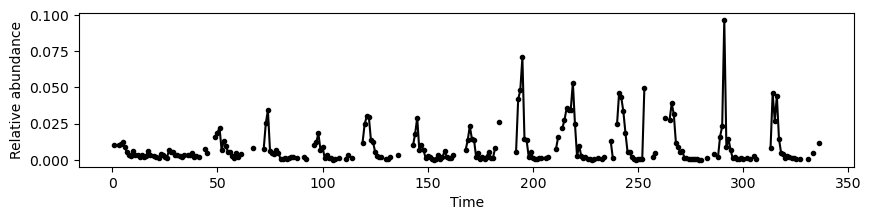

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load MAG-level relative abundance time series
x_df = pd.read_csv("data/MAG_TSS_test.csv", index_col=0)
time = x_df.columns.astype(int)

# Plot
i = 0
plt.figure(figsize=(10,2))
plt.plot(time,x_df.iloc[i],label=x_df.index[i],c='k',marker='o',ms=3)
plt.xlabel('Time')
plt.ylabel('Relative abundance')

# Display basic structure
x_df.head()

### Step 1: Compute local significance score $w(t)$

We quantify local rhythmic transitions in each time series by computing the **signed log p-value** $w(t)$ derived from **Fisher’s exact test**.  
This non-parametric score captures significant upward (positive) and downward (negative) transitions relative to a 24-hour moving median trend,  
allowing the detection of oscillatory signals even under noisy, unevenly sampled, or non-sinusoidal microbiome dynamics.

- **Input:**  
  `x_df` — matrix of abundance time series (rows = taxa/MAGs, columns = time points)  
  Missing sampling times are represented as `NaN` in the DataFrame.

- **Output:**  
  `w_df` — matrix of local significance scores $w(t)$  
  (rows = taxa/MAGs, columns = time points)

The following code computes $w(t)$ for each time series in parallel:

,1,2,3,4,5,6,7,8,9,10,...,327,328,329,330,331,332,333,334,335,336
MAG_001,0.0,0.0,0.0,-0.322219,-0.669007,-1.044670,-1.454845,-1.907143,-1.197449,-0.738351,...,-0.000000,0.239223,0.239223,0.239223,0.239223,0.686381,0.686381,0.327359,0.327359,0.327359
MAG_002,0.0,0.0,0.0,-0.322219,-0.669007,-1.044670,-1.454845,-1.907143,-2.412293,-2.986324,...,0.531479,0.239223,0.239223,0.239223,0.239223,0.686381,0.686381,0.327359,0.327359,0.327359
MAG_003,0.0,-0.0,-0.0,0.000000,-0.243038,0.000000,-0.204774,0.000000,-0.000000,0.000000,...,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000
MAG_004,0.0,-0.0,-0.0,0.000000,-0.000000,0.231757,-0.000000,0.197146,0.441946,0.180823,...,-0.239223,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.327359,0.327359,0.327359
MAG_005,0.0,-0.0,-0.0,0.000000,-0.000000,0.231757,0.507551,0.827961,1.197449,1.624596,...,-0.239223,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.327359,0.327359,0.327359


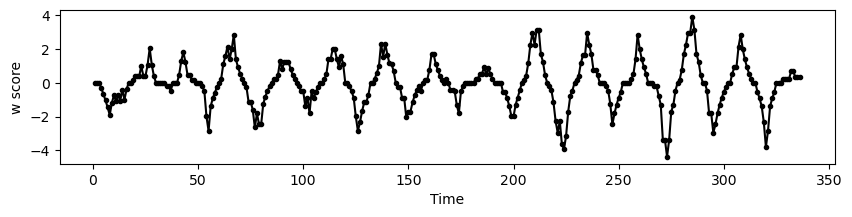

In [5]:
w_df = calc_wscore_parallel(x_df, window_size = 12)

# Plot
i = 0
plt.figure(figsize=(10,2))
plt.plot(time,w_df.iloc[i],label=x_df.index[i],c='k',marker='o',ms=3)
plt.xlabel('Time')
plt.ylabel('w score')

# Display basic structure
w_df.head()

### Step 2: Assign phase θ(t)
We convert each w-score trajectory $w(t)$ into an instantaneous phase $\theta(t)$
using the zero-crossing–based mapping function (`map_wscore_to_phase`).

- **Input:**  
  `w_df` — matrix of w-scores (rows = taxa/MAGs, columns = time points)\
  `time` — time array

- **Output:**  
  `phase_df` — instantaneous phase wrapped to $[0, 2π)$  
  (rows = taxa/MAGs, columns = time points)

Optionally, unwrapped phase and anchor information are stored for later cycle detection.

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,327.0,328.0,329.0,330.0,331.0,332.0,333.0,334.0,335.0,336.0
MAG_001,0.000000,0.224399,0.448799,0.673198,0.897598,1.121997,1.346397,1.570796,1.729767,1.888737,...,3.290595e+00,3.536281,3.781966,4.027652,4.273337,4.519023,4.764708,5.010394,5.256079,5.501765
MAG_002,0.000000,0.157080,0.314159,0.471239,0.628319,0.785398,0.942478,1.099557,1.256637,1.413717,...,4.329005e+00,4.604826,4.880647,5.156468,5.432288,5.708109,5.983930,6.259751,0.252387,0.528207
MAG_003,0.000000,0.076624,0.153248,0.229873,0.306497,0.383121,0.459745,0.536369,0.612994,0.689618,...,7.105427e-15,0.112200,0.224399,0.336599,0.448799,0.560999,0.673198,0.785398,0.897598,1.009798
MAG_004,2.917193,3.141593,3.365992,3.590392,3.814791,4.039191,4.263590,4.487990,4.712389,5.001681,...,2.587859e+00,2.757369,2.926880,3.096390,3.265901,3.435411,3.604922,3.774432,3.943943,4.113453
MAG_005,2.967060,3.141593,3.316126,3.490659,3.665191,3.839724,4.014257,4.188790,4.363323,4.537856,...,2.322774e+00,2.573433,2.824092,3.074751,3.325410,3.576069,3.826728,4.077387,4.328047,4.578706


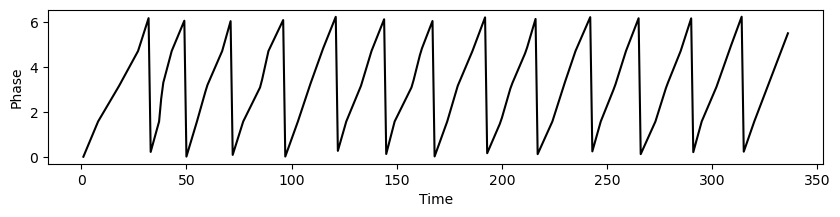

In [6]:
phase_df, aux_dict = compute_phase_from_wscore(w_df, time, smooth_win=5, wrap="0-2pi", return_aux=True)

# Plot
i = 0
plt.figure(figsize=(10,2))
plt.plot(time,phase_df.iloc[i],label=x_df.index[i],c='k')
plt.xlabel('Time')
plt.ylabel('Phase')

# Display basic structure
phase_df.head()

### Step 3: Cycle detection and summarization
Using the unwrapped phase trajectories, w-scores, and abundance data,
we identify valid oscillatory cycles per taxon.

Each detected cycle satisfies:

1.  Amplitude (|w_peak| + |w_trough|)/2 ≥ `ws_thresh`  
2.  Mean abundance ≥ `abund_thresh`  
3.  Duration ∈ [`min_len`, `max_len`]

- **Input:**  
  `phase_df`, `w_df`, `x_df`, and time array `time`

- **Output:**  
  `summary_df` — per-taxon table of valid cycles:  
  columns = [`n_cycles`, `t_start`, `t_end`, `t_peaks`, `longest_run`]

In [7]:
summary_df = detect_valid_cycles_per_taxon(
    phase_df, w_df, x_df, time,
    ws_thresh=1.0, abund_thresh=1e-4, min_len=16, max_len=32
)
summary_df.head()

,n_cycles,t_start,t_end,t_peaks,longest_run
taxon,,,,,
MAG_001,14,"[1.0, 17.881066416253, 38.542768223337, 59.739...","[17.881066416253, 38.542768223337, 59.73962695...","[17.881066416253, 17.881066416253, 38.54276822...",14
MAG_002,10,"[1.0, 75.051453475687, 106.682585489002, 130.8...","[17.281296691706, 106.682585489002, 130.836235...","[17.281296691706, 75.051453475687, 106.6825854...",9
MAG_003,6,"[89.311154522926, 132.333333333333, 180.0, 203...","[112.007025884905, 156.697726904357, 203.88447...","[89.311154522926, 132.333333333333, 180.0, 203...",4
MAG_004,6,"[118.472767560451, 142.350103196214, 162.45871...","[142.350103196214, 162.458710379499, 186.32473...","[118.472767560451, 142.350103196214, 162.45871...",3
MAG_005,13,"[2.0, 29.0, 51.752408293413, 74.282709951702, ...","[29.0, 51.752408293413, 74.282709951702, 95.97...","[2.0, 29.0, 51.752408293413, 74.282709951702, ...",13


In [8]:
phase_df.to_csv('input_for_PhaseAnalysis/MAG_test_phase.csv')
summary_df.to_csv('input_for_PhaseAnalysis/MAG_test_summary.csv')